In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!chmod 600 /content/kaggle.json

In [5]:
!kaggle datasets download amirberenji/brushless-dc-motor-sound-dataset-for-pdm

Dataset URL: https://www.kaggle.com/datasets/amirberenji/brushless-dc-motor-sound-dataset-for-pdm
License(s): Attribution 4.0 International (CC BY 4.0)


In [6]:
!pip install patool pyunpack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 4.0 MB/s eta 0:00:00


In [7]:
from pyunpack import Archive
zip_file_path = '/content/brushless-dc-motor-sound-dataset-for-pdm.zip'
extract_directory = '/content/drive/MyDrive/Test_dataset'
# Buka dan ekstrak file ZIP menggunakan patool
Archive(zip_file_path).extractall(extract_directory)

# Output pesan jika ekstraksi selesai
print("Ekstraksi selesai.")

Ekstraksi selesai.


In [14]:
!pip install pydub

In [24]:

import os
import librosa
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pydub import AudioSegment
import pandas as pd
import IPython
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import freqz, firwin, get_window

In [25]:
# Your existing data loading code
base_dir = '/content/drive/MyDrive/Test_dataset/BLDC_sound_data/'

data = {
    'file_name': [],
    'motor': [],
    'state': [],
    'signal': [],
}

for state in os.listdir(base_dir):
    state_path = os.path.join(base_dir, state)
    if os.path.isdir(state_path):
        for motor in os.listdir(state_path):
            motor_path = os.path.join(state_path, motor)
            if os.path.isdir(motor_path):
                for file in os.listdir(motor_path):
                    if file.endswith('.wav'):
                        file_path = os.path.join(motor_path, file)
                        y, sr = librosa.load(file_path, sr=16000)
                        data['signal'].append(y[:160000])
                        data['motor'].append(motor)
                        data['state'].append(state)
                        data['file_name'].append(file)

x = np.array(data['signal'])

In [26]:
x = np.array(data['signal'])
x.shape

(43, 160000)

In [27]:
def splitter(array, win_len, hop_len, return_df=True):
    N = array.shape[0]
    m = 0
    ids = []
    while m + win_len <= N:
        ids.append([m, m + win_len])
        m = m + hop_len

    if return_df:
        return pd.DataFrame([array[i[0]: i[1]] for i in ids])
    else:
        return np.array([array[i[0]: i[1]] for i in ids])

In [28]:
data_seqs = {
    'motor': [],
    'state': [],
    'signal': [],
}

for i in range(len(data['signal'])):
    arrays = splitter(data['signal'][i], 40000, 20000, return_df=False)
    for j in range(arrays.shape[0]):
        data_seqs['signal'].append(arrays[j, :])
        data_seqs['motor'].append(data['motor'][i])
        data_seqs['state'].append(data['state'][i])

# Convert to numpy array for easier manipulation
X = np.array(data_seqs['signal'])
y = np.array(data_seqs['state'])

In [29]:
# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Classes: {le.classes_}")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)


Classes: ['Bearing' 'Healthy' 'Propeller']


In [30]:
# 1. Specify filter specifications
# ---------------------------------------------------
# Filter parameters
fs = 16000  # Sampling frequency (Hz)
# We'll create multiple bandpass filters to extract features from different frequency ranges
filter_banks = [
    # (type, passband_low, passband_high, transition_width, ripple_passband, ripple_stopband)
    ('bandpass', 20, 200, 50, 0.1, 60),     # Low frequency range (motor base)
    ('bandpass', 200, 800, 100, 0.1, 60),   # Mid-low range (bearing damage might be here)
    ('bandpass', 800, 2000, 200, 0.1, 60),  # Mid-high range (propeller issues)
    ('bandpass', 2000, 5000, 400, 0.1, 60), # High frequency range (other issues)
]

In [31]:
# 2. Calculate filter coefficients using windowing method
# ---------------------------------------------------
def design_fir_filter(filter_type, fs, passband, transition_width, ripple_passband, ripple_stopband):
    """
    Design FIR filter using windowing method
    """
    # Calculate filter order (N) - rule of thumb for Hamming window
    N = int(3.3 * fs / transition_width)
    # Make sure N is odd for Type I FIR filter
    if N % 2 == 0:
        N += 1

    if filter_type == 'bandpass':
        # Normalize frequencies to Nyquist frequency
        low_cutoff = passband[0] / (0.5 * fs)
        high_cutoff = passband[1] / (0.5 * fs)

        # Design filter using firwin with Hamming window
        taps = firwin(N, [low_cutoff, high_cutoff], pass_zero=False, window='hamming')
    elif filter_type == 'lowpass':
        cutoff = passband / (0.5 * fs)
        taps = firwin(N, cutoff, window='hamming')
    elif filter_type == 'highpass':
        cutoff = passband / (0.5 * fs)
        taps = firwin(N, cutoff, pass_zero=False, window='hamming')

    return taps

# Design and create our filter bank
filter_bank_taps = []
for filter_spec in filter_banks:
    filter_type, low_freq, high_freq, transition_width, ripple_passband, ripple_stopband = filter_spec
    taps = design_fir_filter(filter_type, fs, [low_freq, high_freq], transition_width, ripple_passband, ripple_stopband)
    filter_bank_taps.append(taps)

In [32]:
# 3. Filter realization and feature extraction
# ---------------------------------------------------
def extract_features_with_filter_bank(audio_data, filter_bank):
    """
    Apply each filter in the bank to the audio and extract statistical features
    """
    features = []

    for taps in filter_bank:
        # Apply FIR filter
        filtered_signal = signal.lfilter(taps, [1.0], audio_data)

        # Extract statistical features from the filtered signal
        features.extend([
            np.mean(np.abs(filtered_signal)),  # Mean absolute value
            np.std(filtered_signal),           # Standard deviation
            np.max(np.abs(filtered_signal)),   # Max absolute value
            np.sum(filtered_signal**2),        # Energy
            np.mean(filtered_signal**2),       # Mean squared value
            np.sum(np.abs(np.diff(filtered_signal))), # Sum of absolute differences
            np.mean(librosa.feature.rms(y=filtered_signal)[0]), # RMS energy
            np.percentile(np.abs(filtered_signal), 90)  # 90th percentile
        ])

    return np.array(features)

# Extract features for training and test sets
X_train_features = np.array([extract_features_with_filter_bank(x, filter_bank_taps) for x in X_train])
X_test_features = np.array([extract_features_with_filter_bank(x, filter_bank_taps) for x in X_test])

In [33]:
# 4. Analyze wordlength (bit precision) - Simulating quantization effects
# ---------------------------------------------------
def quantize_signal(signal, bits):
    """Simulate quantization to specified bit depth"""
    max_val = np.max(np.abs(signal))
    if max_val == 0:  # Avoid division by zero
        return signal

    step = 2 * max_val / (2**bits - 1)
    return np.round(signal / step) * step

# Test different bit depths and measure their impact on filter performance
bit_depths = [8, 12, 16, 24]
quantization_errors = []

for bits in bit_depths:
    # Quantize one test sample
    sample_idx = 0
    original_filtered = extract_features_with_filter_bank(X_test[sample_idx], filter_bank_taps)
    quantized_signal = quantize_signal(X_test[sample_idx], bits)
    quantized_filtered = extract_features_with_filter_bank(quantized_signal, filter_bank_taps)

    # Calculate error
    error = np.mean(np.abs(original_filtered - quantized_filtered) / (np.abs(original_filtered) + 1e-10))
    quantization_errors.append(error)
    print(f"Bit depth: {bits}, Average relative error: {error:.6f}")

# Train a classifier with the features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, y_train)

# Make predictions
y_pred = clf.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Bit depth: 8, Average relative error: 0.000649
Bit depth: 12, Average relative error: 0.000047
Bit depth: 16, Average relative error: 0.000006
Bit depth: 24, Average relative error: 0.000000
Accuracy: 0.9890


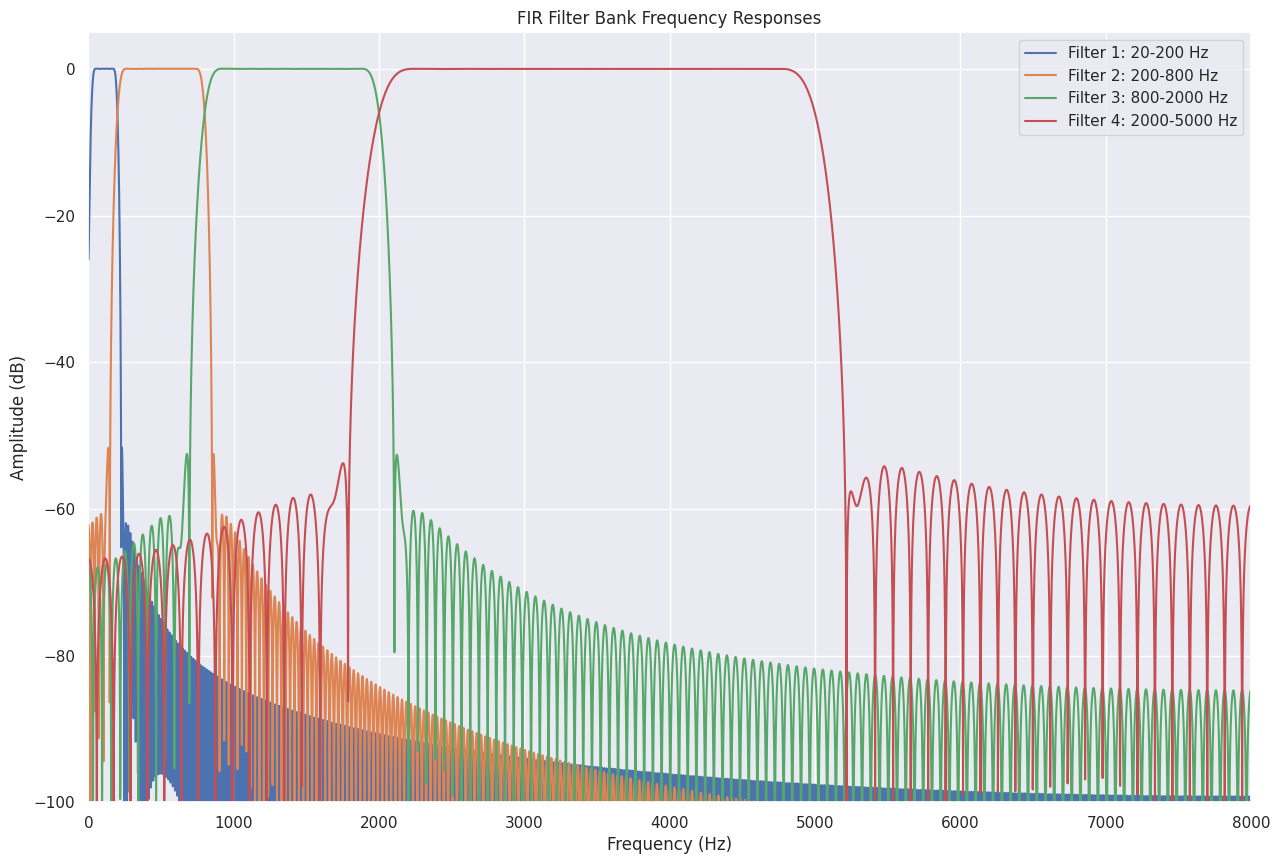

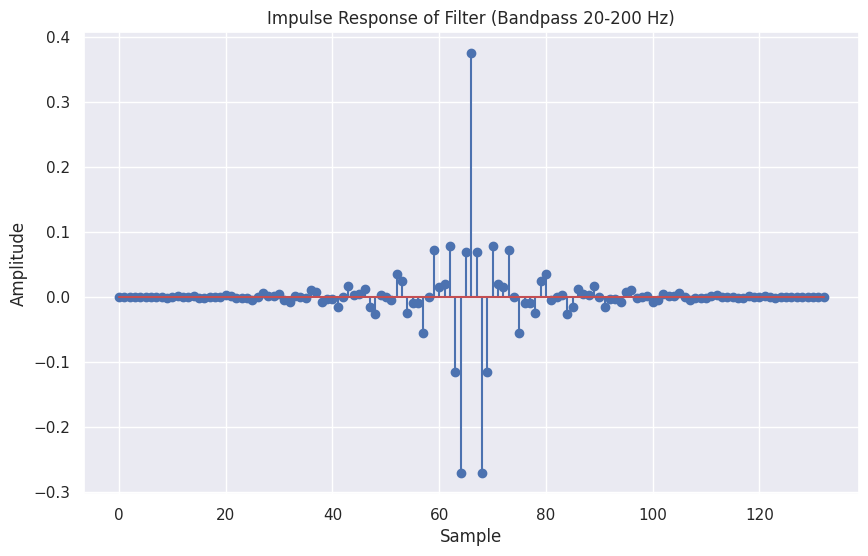

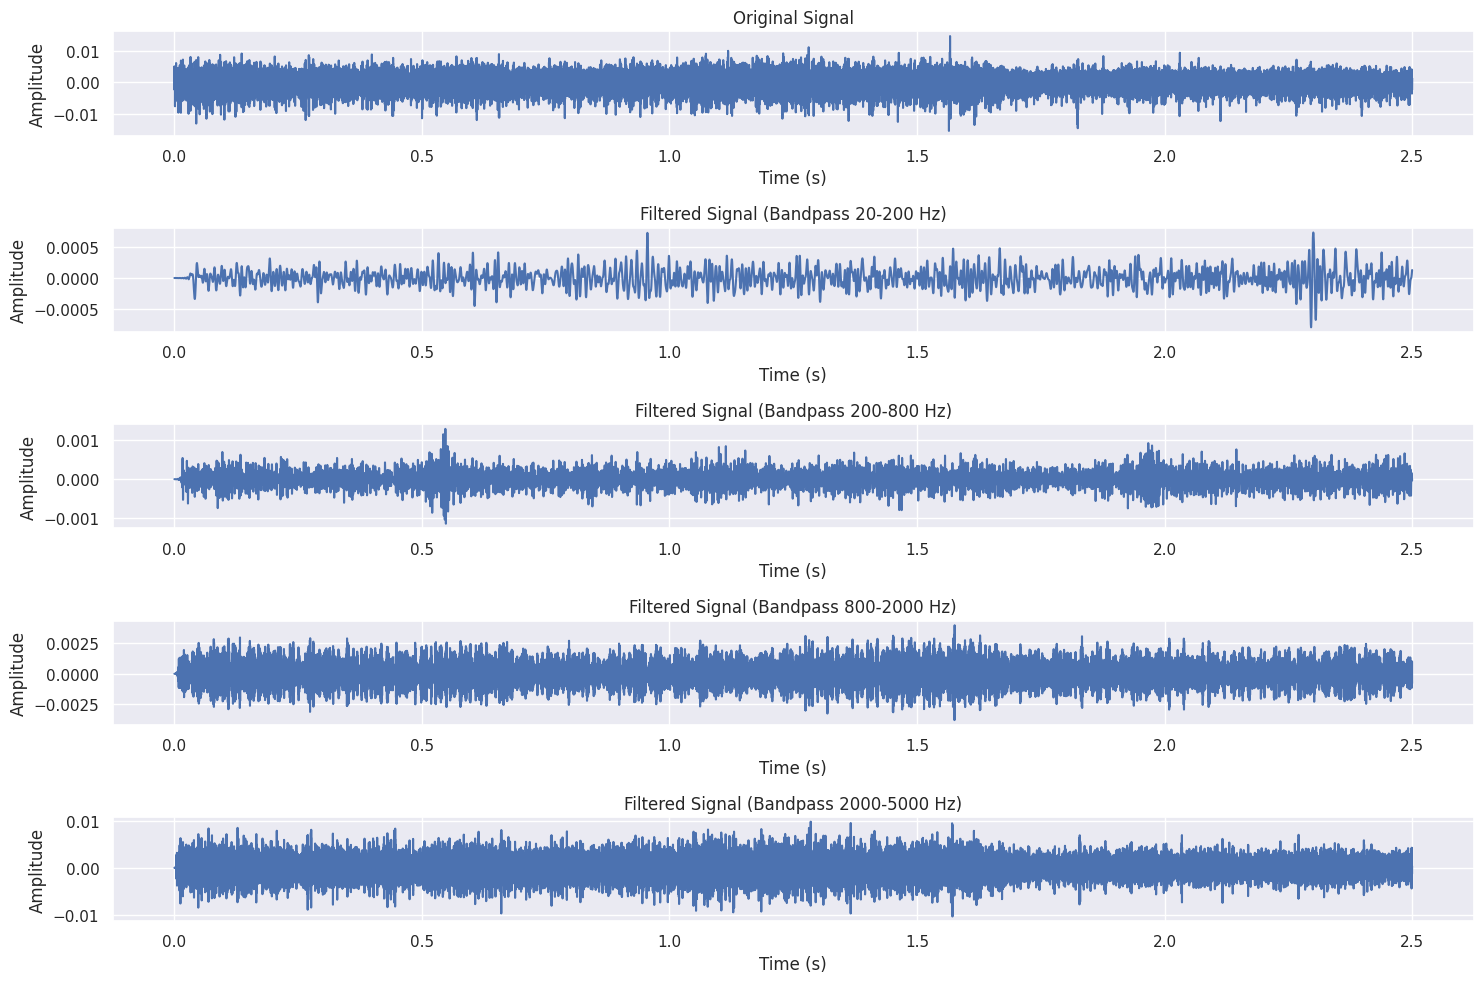

<Figure size 1000x800 with 0 Axes>

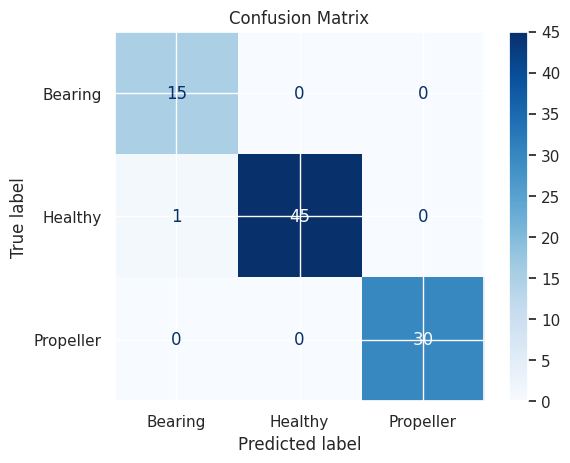

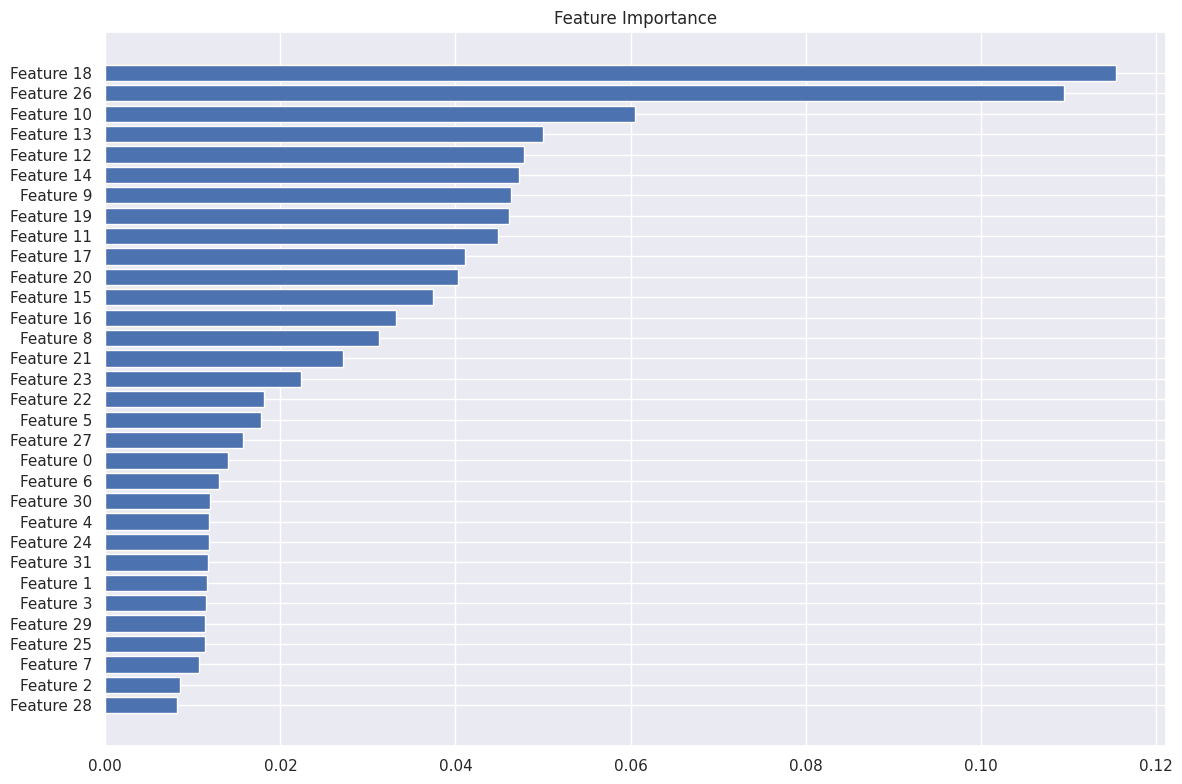

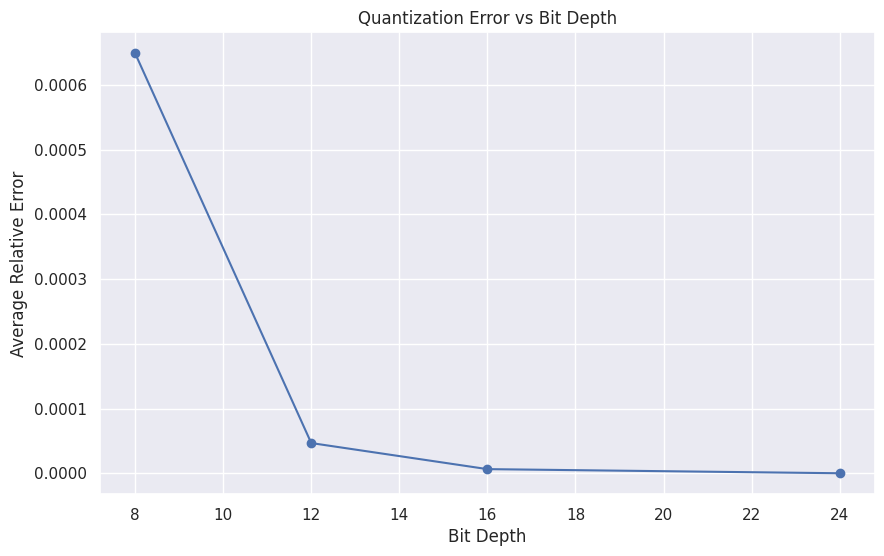

In [35]:
# 5. Plot necessary results
# ---------------------------------------------------
# 5.1 Plot filter frequency responses
plt.figure(figsize=(15, 10))
for i, taps in enumerate(filter_bank_taps):
    w, h = freqz(taps, worN=8000)
    plt.plot((fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)),
             label=f'Filter {i+1}: {filter_banks[i][1]}-{filter_banks[i][2]} Hz')

plt.title('FIR Filter Bank Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.xlim(0, fs/2)
plt.ylim(-100, 5)
plt.show()

# 5.2 Plot a filter's impulse response
plt.figure(figsize=(10, 6))
# Remove 'use_line_collection' argument if using Matplotlib version < 3.1
# If using Matplotlib version >= 3.1, keep the argument for better performance
# plt.stem(taps, use_line_collection=True)
plt.stem(taps)  # Use this line if 'use_line_collection' causes an error
plt.title(f'Impulse Response of Filter (Bandpass {filter_banks[0][1]}-{filter_banks[0][2]} Hz)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 5.3 Plot original vs filtered signal
plt.figure(figsize=(15, 10))
sample_idx = 0  # Index of the sample to visualize
sample = X_test[sample_idx]
time = np.arange(len(sample)) / fs

plt.subplot(len(filter_bank_taps) + 1, 1, 1)
plt.plot(time, sample)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

for i, taps in enumerate(filter_bank_taps):
    # Apply FIR filter
    filtered_signal = signal.lfilter(taps, [1.0], sample)

    plt.subplot(len(filter_bank_taps) + 1, 1, i + 2)
    plt.plot(time, filtered_signal)
    plt.title(f'Filtered Signal (Bandpass {filter_banks[i][1]}-{filter_banks[i][2]} Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 5.4 Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 5.5 Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [f"Feature {i}" for i in sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 5.6 Plot quantization error vs bit depth
plt.figure(figsize=(10, 6))
plt.plot(bit_depths, quantization_errors, marker='o')
plt.title('Quantization Error vs Bit Depth')
plt.xlabel('Bit Depth')
plt.ylabel('Average Relative Error')
plt.grid(True)
plt.show()